### ML acidoCEST
- Code source: [link](https://scikit-learn.org/0.15/auto_examples/plot_digits_pipe.html)
- Modified by Julio Cardenas-Rodriguez, Ph.D.
- CAMEL West @Tucson, AZ
- License: TBD

Change Log  
- 2018_06_04: Initial Version

### To -do list
- [ ] Add r-squared
- [ ] 4.3 and 5.5
- [ ] Compare against raw Z-spectra
- [ ] Compare against fitted Lorentzian for all samples
- [ ] Compare using a single calibration curve for linear regression



```python
yhat = p(x)                         # or [p(z) for z in x]
ybar = numpy.sum(y)/len(y)          # or sum(y)/len(y)
ssreg = numpy.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
sstot = numpy.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
results['determination'] = ssreg / sstot
```


In [1]:
molecules = ['Polymer',
             ' Monomer 2 (M2)',
             'Monomer 1 (M1)',
             'Iopamidol',
             'Gadolinium in 20mM Iopamidol']
n = 3

In [2]:
### Libraries
import numpy as np
import pandas as pd
import scikitplot as skplt
import matplotlib.pyplot as plt

from sklearn import linear_model, decomposition, datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.decomposition import PCA
%matplotlib inline

import curve_fitting as cf
import imp
imp.reload(cf)

def center_ppm(xdata,Y):
    return xdata - xdata[np.argmax(1-Y)]
    

In [3]:
data_file ='../data/raw/CEST-ML-format_mdp_20181121_230pm_JCR_CJK_20190415.xlsx'


df         = pd.read_excel(data_file, sheetname= molecules[n])

In [4]:
info = df[['Sample ID', 'pH', 'concentration_mM','temperature_C', 'sat time_sec','sat power_uT']]
pH = info['pH'].copy()
print('Info shape \n',info.shape)
print('--'*10)
X = df.select_dtypes(include=['float64']).drop(['pH', 'sat time_sec',     'sat power_uT'],axis = 1)
print('X shape \n', X.shape )
print('--'*10)
for C in info.columns:  
    print(info[C].nunique(), C + ' unique values')
    print('--'*10)

Info shape 
 (585, 6)
--------------------
X shape 
 (585, 142)
--------------------
1 Sample ID unique values
--------------------
15 pH unique values
--------------------
7 concentration_mM unique values
--------------------
5 temperature_C unique values
--------------------
7 sat time_sec unique values
--------------------
6 sat power_uT unique values
--------------------


### Some spectra

In [5]:
info.iloc[0::60,:]

,Sample ID,pH,concentration_mM,temperature_C,sat time_sec,sat power_uT
0,Iopamidol,6.0,30,37,6.0,0.5
60,Iopamidol,6.0,30,37,6.0,4.0
120,Iopamidol,6.0,30,37,1.5,4.0
180,Iopamidol,6.0,30,37,6.0,4.0
240,Iopamidol,6.0,30,47,6.0,4.0
300,Iopamidol,6.0,15,37,6.0,4.0
360,Iopamidol,6.0,50,37,6.0,1.0
420,Iopamidol,6.0,50,37,0.5,4.0
480,Iopamidol,6.0,50,37,3.0,4.0
540,Iopamidol,6.0,50,32,6.0,4.0


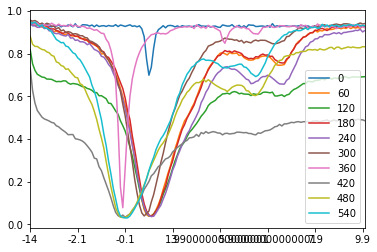

In [6]:
X.iloc[0::60,:].T.plot()

## Fitting Parameters

In [7]:
a1= .9
a2= .7
a3= .5
a4= .5

w1= 1
w2= 1
w3= 1
w4= 1

c1= 0
c2= 1
c3= 4.2
c4= 5.6

x0 = [a1,a2,a3,a4,   w1,w2,w3,w4,  c1,    c2,   c3,   c4,  1]
lb = [.1, 0,0,  0,   .1,.1,.1,.1,  c1-.1, .5,   c3-1, c4-.5,   -2]
ub = [1, .7,1,1,    3, 2, 2, 2,    c1+.1, 2.0 , c3+1, c4+.5, 2]  

d = pd.DataFrame(lb, columns=['lb'])
d['xo'] = x0
d['ub'] = ub

d.index = ['A1','A2','A3','A4','W1','W2','W3','W4','C1','C2','C3','C4','Scaling']
d

,lb,xo,ub
A1,0.1,0.9,1.0
A2,0.0,0.7,0.7
A3,0.0,0.5,1.0
A4,0.0,0.5,1.0
W1,0.1,1.0,3.0
W2,0.1,1.0,2.0
W3,0.1,1.0,2.0
W4,0.1,1.0,2.0
C1,-0.1,0.0,0.1
C2,0.5,1.0,2.0


### Test some of the fitting

Sample ID            NaN
pH                  6.75
concentration_mM      30
temperature_C         37
sat time_sec           6
sat power_uT         0.5
Name: 5, dtype: object


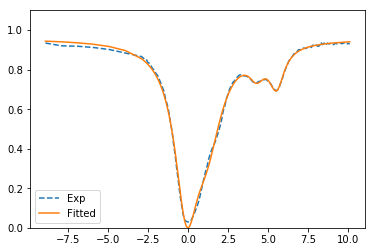

In [8]:
f = 5
s = 540


print(info.iloc[5,:])

y_data =  X.iloc[s,:].values[f::]
x_data =  center_ppm( X.columns.values[f::], y_data)

par_hat = cf.fit_lorentzian(x_data, 1-y_data, x0, lb, ub )
yhat = cf.lorentzian(x_data,par_hat)

plt.figure()
plt.plot(x_data, y_data,'--')
plt.plot(x_data, 1-yhat,'-')
plt.legend(['Exp','Fitted'])
plt.ylim([0,1.1])
plt.show()



In [9]:
%%time
info = info.assign(Peak_4p2 = 1)
info = info.assign(Peak_5p6 = 1)
peak_01 = []
peak_02 = []
for s in range(X.shape[0]):
    y_data =  X.iloc[s,:].values[f::]
    x_data =  center_ppm( X.columns.values[f::], y_data)
    par_hat = cf.fit_lorentzian(x_data, 1-y_data, x0, lb, ub )
    peak_01.append(par_hat[2])
    peak_02.append(par_hat[3])
    
    # peaks for ratiometric approach
    info.loc[s,'Peak_4p2'] = ( 1-(1-par_hat[2]) ) / (1-par_hat[2])   #par_hat[2]
    info.loc[s,'Peak_5p6'] = ( 1-(1-par_hat[3]) ) / (1-par_hat[3])   # par_hat[3]
    

CPU times: user 1min 3s, sys: 228 ms, total: 1min 4s
Wall time: 1min 4s


### Linear Model Ratios

## - Calibration Curve

In [207]:
info['RATIO'] = np.log10( info['Peak_4p2'] / info['Peak_5p6'])

f1 = info.concentration_mM == 30
f2 = info.temperature_C == 37
f3 = info['sat time_sec'] == 6
f4 = info['sat power_uT'] ==3
d = info[f1&f2&f3&f4]
d = d[d.pH <= 7.4]

In [208]:
d

,Sample ID,pH,concentration_mM,temperature_C,sat time_sec,sat power_uT,Peak_4p2,Peak_5p6,RATIO
45,Iopamidol,6.00,30,37,6.0,3.0,0.077342,0.142377,-0.265024
46,NaN,6.15,30,37,6.0,3.0,0.104652,0.168066,-0.205731
47,NaN,6.30,30,37,6.0,3.0,0.146265,0.176628,-0.081921
48,NaN,6.45,30,37,6.0,3.0,0.214180,0.184572,0.064614
49,NaN,6.60,30,37,6.0,3.0,0.271126,0.149910,0.257342
50,NaN,6.75,30,37,6.0,3.0,0.345238,0.116184,0.472972
51,NaN,6.90,30,37,6.0,3.0,0.485333,0.068082,0.853005
52,NaN,7.00,30,37,6.0,3.0,0.457704,0.034537,1.122297
53,NaN,7.15,30,37,6.0,3.0,0.461719,0.011342,1.609688
54,NaN,7.30,30,37,6.0,3.0,0.371852,0.003381,2.041301



MSE 
 0.012448656107239197

MSE 
 0.09766768965758796


(array([316.,  33.,  14.,   8.,   7.,   3.,   1.,   2.,   4.,   2.]),
 array([1.10440015e-07, 1.21046457e-01, 2.42092804e-01, 3.63139151e-01,
        4.84185497e-01, 6.05231844e-01, 7.26278191e-01, 8.47324538e-01,
        9.68370884e-01, 1.08941723e+00, 1.21046358e+00]),
 <a list of 10 Patch objects>)

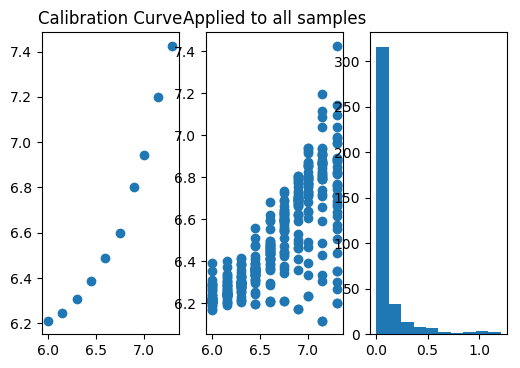

In [209]:
Xd = d['RATIO'].values.reshape(-1,1)

LR = linear_model.LinearRegression(  fit_intercept=True)
LR.fit(Xd,d.pH)
pHhat = LR.predict(Xd)


f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, dpi=100)

ax1.plot(d.pH, pHhat,'o')
ax1.set_title('Calibration Curve')
#ax1.ylim([5.5,7.5])

print()
print('MSE \n',metrics.regression.mean_squared_error(d.pH,LR.predict(Xd)))


## Apply Calibriton to everything

I = info[info.pH <= 7.4]

Xd = I['RATIO'].replace(np.inf,0)
Xd = Xd.values.reshape(-1,1)

yd = I.pH.copy()

pHhat1 = LR.predict(Xd)


ax2.plot(yd, pHhat1,'o')
ax2.set_title('Applied to all samples')

print()
print('MSE \n',metrics.regression.mean_squared_error(yd,pHhat1))

ax3.hist( (yd - pHhat1)**2)

## Train on all variables and test on all data

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:    2.5s finished



MSE 
 0.0671399215043536


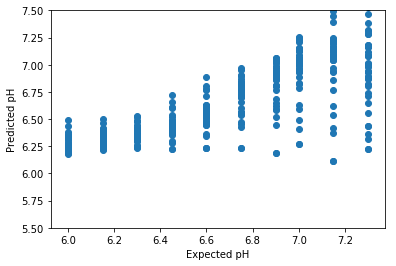

In [210]:
model_all = train_linear_regression(Xd, yd)

pHhat2 = model_all.predict(Xd)

plt.scatter(yd, pHhat2)
plt.xlabel('Expected pH')
plt.ylabel('Predicted pH')
plt.ylim([5.5,7.5])

print()
print('MSE \n',metrics.regression.mean_squared_error(yd,pHhat2))

### Train on Spectra and test on everything

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:    0.2s finished



MSE 
 0.035727903102311914


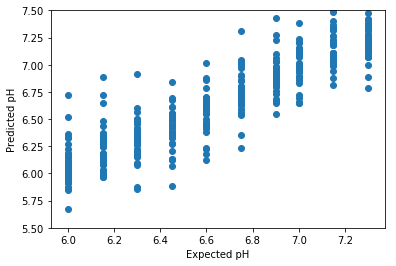

In [211]:
Xd = X[info.pH <= 7.4]
yd = info.pH[info.pH <= 7.4]

model_all = train_linear_regression(Xd, yd)

pHhat3 = model_all.predict(Xd)

plt.scatter(yd, pHhat3)
plt.xlabel('Expected pH')
plt.ylabel('Predicted pH')
plt.ylim([5.5,7.5])


print()
print('MSE \n',metrics.regression.mean_squared_error(yd,pHhat3))

### Train on Spectra + PCA and test on everything

In [212]:
Xd.shape

(390, 142)

Fitting 3 folds for each of 492 candidates, totalling 1476 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 310 tasks      | elapsed:    2.1s
[Parallel(n_jobs=3)]: Done 1476 out of 1476 | elapsed:    9.6s finished



MSE 
 0.04169372423912112


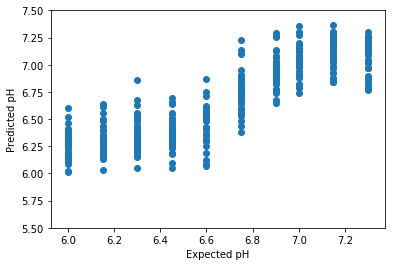

In [213]:
model_pca = train_linear_reg_pipeline(Xd, yd, max_n= 125)

pHhat4 = model_pca.predict(Xd)

plt.scatter(yd, pHhat4)
plt.xlabel('Expected pH')
plt.ylabel('Predicted pH')
plt.ylim([5.5,7.5])


print()
print('MSE \n',metrics.regression.mean_squared_error(yd,pHhat4))

In [215]:
model_pca

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=21, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True))])

(array([312.,  47.,  14.,   9.,   6.,   1.,   0.,   0.,   0.,   1.]),
 array([5.02518887e-07, 6.52064783e-02, 1.30412454e-01, 1.95618430e-01,
        2.60824406e-01, 3.26030381e-01, 3.91236357e-01, 4.56442333e-01,
        5.21648309e-01, 5.86854284e-01, 6.52060260e-01]),
 <a list of 10 Patch objects>)

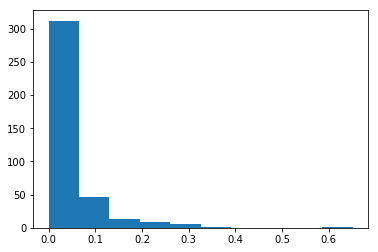

In [214]:
plt.hist( (yd - pHhat4)**2)

#### Logistic Regression

In [142]:
### define function to train model based on cuttoff for pH
def train_linear_reg_pipeline(Spectra, pH_observed, min_n=2, max_n= 10):
    # cut off > pH
    y = pH_observed
    # X data
    X = Spectra.copy()
        
    # Logistic
    linear = linear_model.LinearRegression( )
    
    #PCA
    pca = PCA(random_state=42)
    
    # pipeline
    pipe = Pipeline(steps=[('pca', pca), ('linear', linear)])
    
    # Training parameters
    num_pca_components = np.arange(min_n,max_n,1)


    param_grid ={
    'pca__n_components': num_pca_components,
    'linear__normalize': [True,False],
    'linear__fit_intercept':[True,False]
    }
    
    
    estimator = GridSearchCV(pipe, param_grid, verbose = 1, cv = 3, n_jobs=3, iid = True)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    # Grid Search of Model
    estimator.fit(X_train, y_train)

    
    return estimator.best_estimator_

In [110]:
### define function to train model based on cuttoff for pH
def train_linear_regression(Spectra, pH_observed):
    # cut off > pH
    y = pH_observed
    # X data
    X = Spectra.copy()
        
    # Logistic
    linear = linear_model.LinearRegression( )

    # Training parameters
    param_grid ={
    'normalize': [True,False],
        'fit_intercept':[False,True]
    }
    
    
    estimator = GridSearchCV(linear, param_grid, verbose = 1, cv = 3, n_jobs=3, iid = True)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    # Grid Search of Model
    estimator.fit(X_train, y_train)
        
    return estimator.best_estimator_

    # Grid Search on Pipeline
    estimator = GridSearchCV(logistic,
                         dict(
                              C= Cs,
                              class_weight= ['balanced',None],
                              fit_intercept= [True,False]), 
                             verbose = 1, cv = 3, n_jobs=3, iid = True)

Note on metrics
- precision = positive predictive value
- recall    = sensitivity

###  -training pH >7.0  

In [ ]:
(pH> 7).value_counts(normalize = True).round(2)

### Pipeline

In [ ]:
s = X.shape[1]
step_size = 1

In [ ]:
clf_01, Xtrain, Xtest, ytrain, ytest = train_logistic_PCA_pipeline( X.iloc[:,0:s:step_size], pH,
                                                                           min_n=2, max_n= 10,
                                                                           pH_cut_off = 7.0, n_cs=20 )

clf_01

### Only Logistic Regression

In [ ]:
clf_01, Xtrain, Xtest, ytrain, ytest = train_logistic_regression( X.iloc[:,0:s:step_size], pH,
                                                                           pH_cut_off = 7.0, n_cs=20 )

### pH > 6.8

In [ ]:
(pH > 6.8).value_counts(normalize = True).round(2)

In [ ]:
clf_pca, Xtrain, Xtest, ytrain, ytest = train_logistic_PCA_pipeline( X.iloc[:,0:s:1], pH,
                                                                           min_n=2, max_n= 10,
                                                                           pH_cut_off = 6.8, n_cs=20 )
clf_pca

For Mart

In [ ]:
pca = clf_pca.named_steps['pca']

In [ ]:
pca.transform(X.iloc[250:251,:])

In [ ]:
clf_pca.predict(X)